In [114]:
# load data
from pathlib import Path
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

fn = 'data/newsroom/newsroom_dev.snappy.parquet'

df = pd.read_parquet(path=str(fn), engine='pyarrow', columns=['text', 'summary'])
df.head()


,text,summary
0,"Van Cliburn, a little-known pianist who in 195...","Van Cliburn, a little-known pianist who in 195..."
1,Republicans need to be very careful about how ...,Ed Rollins puts his party on notice.
2,It is hard to believe in the cold light of day...,"Watching a car go round in circles, chasing a ..."
3,Over 100 dancers and musicians bring Nutcracke...,Get information and buy cheap theatre tickets ...
4,The Federal Reserve will shed more light this ...,The Federal Reserve will shed more light this ...


In [226]:
# count bad entries
text_lens = df['text'].map(lambda x: len(x.strip()))
summary_lens = df['summary'].map(lambda x: len(x.strip()))

print('# empty texts:',(text_lens == 0).sum())
print('# empty summaries:', (summary_lens == 0).sum())
print('# len(summary) > len(text):', (summary_lens > text_lens).values.sum())



# empty texts: 224
# empty summaries: 0
# len(summary) > len(text): 525


In [115]:
# load contriever
cache_dir = '../hf_model_cache'
tokenizer = AutoTokenizer.from_pretrained('facebook/contriever', cache_dir=cache_dir)
model = AutoModel.from_pretrained('facebook/contriever', cache_dir=cache_dir)

device = torch.device('cuda', 0)
model.to(device)

# Mean pooling
def mean_pooling(token_embeddings, mask):
    token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
    sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
    return sentence_embeddings


In [221]:
# compute the cosine similariries between the contriever embeddings of text and summary of all entries
from typing import List
import numpy as np
from torch.nn.functional import cosine_similarity
from tqdm import tqdm


def embed(text_list: List[str], device: torch.DeviceObjType=None):
    tokens = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    if device is not None:
        tokens.to(device)
    outputs = model(**tokens)
    return mean_pooling(outputs[0], tokens['attention_mask'])


@torch.no_grad()
def compute_similarity_scores(texts: pd.Series, summaries: pd.Series, batch_size: int=64, device: torch.DeviceObjType=None):
    scores = []
    n = len(texts)
    assert n == len(summaries)
    for i in tqdm(range(0, n, batch_size)):
        text_list = texts.iloc[i:i+batch_size].to_list()
        summary_list = summaries.iloc[i:i+batch_size].to_list()

        a = embed(text_list, device)
        b = embed(summary_list, device)

        s = cosine_similarity(a, b)
        scores.append(s)

    return torch.cat(scores).cpu().numpy()

def token_counts(column, k=1000):
    token_counts = []
    n = len(column)
    for i in range(0, n, k):
        text = column.iloc[i:i+k].to_list()
        text_tokens = tokenizer(text, padding=False, truncation=False)
        token_counts.extend([len(x) for x in text_tokens['input_ids']])

    return token_counts

batch_size = 512

#n = 10000
n = len(df)

if n < len(df):
    sample_df = df.sample(n=n, random_state=4269, replace=False)
else:
    sample_df = df.copy()
scores = compute_similarity_scores(sample_df['text'], sample_df['summary'], batch_size=batch_size, device=device)
summary_token_counts = np.array(token_counts(sample_df['summary']))
text_token_counts = np.array(token_counts(sample_df['text']))



100%|██████████| 213/213 [24:02<00:00,  6.77s/it]


summary_token_counts(108599): min: 3; max: 1894; mean: 37.0045; meadian: 30.0;
text_token_counts(108599): min: 2; max: 38946; mean: 828.0113; meadian: 667.0;
scores(108599): min: 0.0744; max: 1.0000; mean: 0.4783; median: 0.4741;


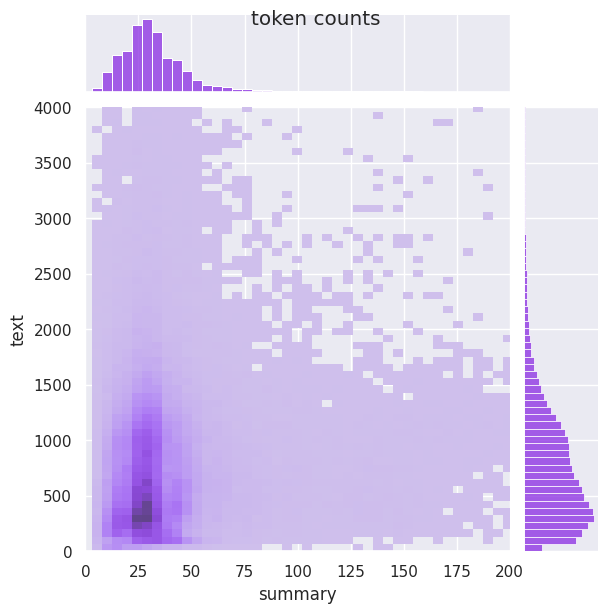

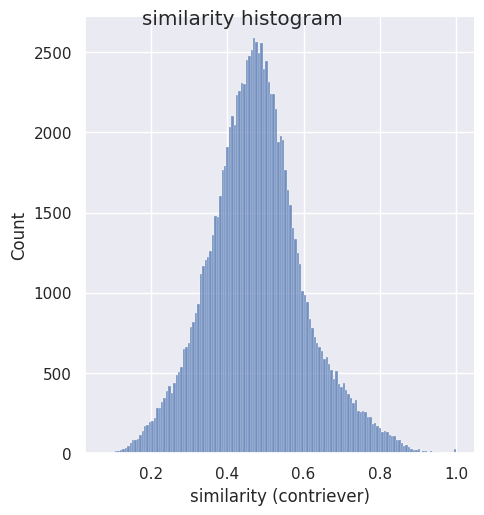

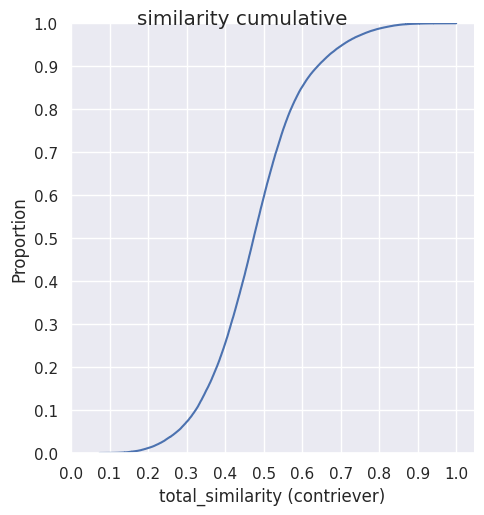

In [224]:
# plot similarity scores
import seaborn as sns
import matplotlib.pyplot as plt

def print_stats(x: np.ndarray, name: str):
    print(f'{name}({len(x)}): min: {x.min():.4f}; max: {x.max():.4f}; mean: {x.mean():.4f}; median: {np.median(x):.4f};')

def print_statsi(x: np.ndarray, name: str):
    print(f'{name}({len(x)}): min: {x.min()}; max: {x.max()}; mean: {x.mean():.4f}; meadian: {np.median(x)};')


sns.set_theme()

print_statsi(summary_token_counts, 'summary_token_counts')
print_statsi(text_token_counts, 'text_token_counts')
print_stats(scores, 'scores')

p = sns.jointplot(x=summary_token_counts, y=text_token_counts, kind="hist", color="blueviolet", xlim=(0,200), ylim=(0, 4000), bins=(400, 600)).set_axis_labels("summary", "text")
p.fig.suptitle('token counts')

p = sns.displot(data=scores, kind="hist", height=5).set(xlabel='similarity (contriever)')
p.fig.suptitle('similarity histogram')
p = sns.displot(data=scores, kind="ecdf", height=5).set(xlabel='total_similarity (contriever)', xticks=np.linspace(0,1,11), yticks=np.linspace(0,1,11))
p.fig.suptitle('similarity cumulative');


In [235]:
# search beginning of text in summary and determine how much text matches
import difflib

text = df['text']
summary = df['summary']

def longest_match_len(a, b):
    s = difflib.SequenceMatcher(None, a, b)
    match = s.find_longest_match(0, min(len(a), 512), 0, len(b))
    return match.size

y = sample_df.apply(lambda x: longest_match_len(x['text'], x['summary']), axis=1)
sum_lens = sample_df['summary'].map(lambda x: len(x))
sample_df['overlap'] = y / sum_lens


In [238]:
# show some examples for different similiary score values
from IPython.display import Markdown, display

sample_df['score'] = scores
scored = sample_df.sort_values('score')

test_scores = np.linspace(0.1,0.9, 14)

output = []

for t in test_scores:
    scores_col = scored['score']  
    i = scores_col[scores_col.gt(t)].idxmin()
    entry = scored.loc[i]

    output.append('----')
    a,o,b,c = entry["score"].item(), entry['overlap'].item(), entry['text'], entry['summary']

    if len(b) > 1500:
        b = b[:1500] + ' (...)'

    if len(c) > 500:
        c = c[:500] + ' (...)'

    output.append(f'## score: {a:.4f} (overlap: {o:.2%})')
    output.append(f'```{b}\n```')
    output.append(f'## summary: {c}')

s = '\n'.join(output)

display(Markdown(s))


----
## score: 0.1013 (overlap: 4.88%)
```I remember sometime back addressing a fairly large group of patients battling multiple sclerosis.

Now many were hurting. A lot were bitter. And more than quite a few were mad.

I want to disclose first that I "have" MS...Not I’m not here to win your sympathy on that...but to put this in context and to put what I told the folks next in context and what I always try to remind myself to this day.

"Quit being a victim," I said.

"You are sick. Some of you are very sick."

It's not fair. It's not right. I’m telling you it just...is.

But I went on to add this...

"It is not your boss's fault you have MS, or your spouse's fault that you have MS, or your kids' fault that you have MS."

"You...we...just got dealt a bad deck of genetic cards. End of story. Move on. Carry on."

I remember some clapping, just some. But afterwards, I remember more than a few complaining that I didn't know their pain or the callousness of others in the face of their pain.

I disagree. I did. But I said then, as I do now, and this is the cruel part…get over it.

You have lives to live. They have lives to live. Live them.

My only point in recounting that story, again, is not to make you feel sorry for me...although I hope you'll keep that in mind if I have a lousy show...

My point is to address this bigger trend in our society to play victim...to play the "woe is me card."

I think the president's the latest to do that. But he’s far from the "only" one to try that.

Constantly referring to the awful mes (...)
```
## summary: Your World w/ Cavuto on FoxNews.com - follow Neil Cavuto on Weekdays at 4:00 PM ET
----
## score: 0.1616 (overlap: 10.34%)
```One time Barack Obama went to an Indian restaurant and ordered the lassi. Was he ever disappointed when the waiter brought him a yogurt drink!

We'll be here all week. But seriously, folks, we have a man-bites-dog story for you today.

First, some background. Last week Byron York of the Washington Examiner reported that "some Obama staffers are reportedly obsessing over a nearly 30-year-old story about [Mitt] Romney's dog":

"I have heard, in focus groups, the dog story totally tanks Mitt Romney's approval rating," Chris Hayes said on his MSNBC show. The Washington Post reported last month that the Seamus story "is ballooning into a narrative of epic proportions":

In January Obama adviser David Axelrod--not to be confused with Axelrod, the Flying A Dog--blew a dog whistle. He tweeted a photo of the president with Bo, the White House canine, in what appears to be the back seat of a limousine. Axelrod's comment: "How loving owners transport their dogs."

In a more serious vein, Lincoln Mitchell of Columbia University's Harriman Institute writes at the Puffington Host: "For many voters, treating a dog this way is unimaginable and could only be done by somebody who has a problem empathizing with others."

But then Jim Treacher, the Daily Caller's resident wag, picked up his dog-eared copy of "Dreams From My Father," Obama's 1995 autobiography, and sniffed out this passage from the second chapter. If Axelrod's tweet was a dog whistle, Treacher's post is a dinner bell:

It reminds (...)
```
## summary: James Taranto on the political perils of personal attacks.
----
## score: 0.2231 (overlap: 33.33%)
```The Securities and Exchange Commission's complaint alleging a massive fraud by Texas billionaires Sam and Charles Wyly paints an unusually detailed picture of how they used hundreds of millions of dollars in allegedly ill-gotten gains to buy art and condos, and make charitable contributions. We should note that a lawyer for the Wylys has denied all the charges. Here are some excerpts from the SEC complaint:

By Zachary Goldfarb | July 29, 2010; 8:17 PM ET Save & Share: Previous: The Wylys respond Next: The Wylys's GOP contributions

Posted by: jimbobkalina | July 30, 2010 2:09 AM | Report abuse

Posted by: Anonymous | July 30, 2010 7:50 AM | Report abuse

Posted by: Anonymous | July 30, 2010 9:09 AM | Report abuse

Posted by: tony_in_Durham_NC | July 30, 2010 1:00 PM | Report abuse

Posted by: Anonymous | July 30, 2010 1:25 PM | Report abuse

Posted by: perryneheum | July 30, 2010 1:33 PM | Report abuse

Posted by: Anonymous | July 30, 2010 4:34 PM | Report abuse

Posted by: abbydelabbey | July 30, 2010 6:25 PM | Report abuse

Posted by: Anonymous | July 31, 2010 5:15 AM | Report abuse

The comments to this entry are closed.
```
## summary: ...
----
## score: 0.2846 (overlap: 4.39%)
```Timothy Egan on American politics and life, as seen from the West.

Timothy Egan on American politics and life, as seen from the West.

CHINLE, Ariz. — On the floor of Canyon de Chelly, what pops up in three dimensions of desert light are the remains of 900-year-old stone apartments, the graveyard of peach trees cut down by Kit Carson’s Indian killers, and sandstone walls that drew the cameras of Edward Curtis and Ansel Adams.

But it’s much more than a still life. Here is a Navajo farmer, tilling corn and squash in red dirt next to a home in the shape of the traditional hogan, door facing the rising sun. There is the sound of sheep bells bouncing off spires the size of the Washington Monument. And just now comes a runner in braids, grinding up vertical feet under the midday sun.

This federal monument, where the past is not dead or even past, is alive like no other unit of the National Park Service. People live in the Canyon de Chelly (pronounced d’SHAY), and they are much more than props for all those visitors from France and Germany. As the national parks try to reinvent themselves in an age when people are bored by anything that can’t be delivered by smart phone, one model is the Indian way.

For Canyon de Chelly is a fascinating hybrid: it’s administered by the Park Service, but is entirely within the confines of the Navajo Nation, which is bigger in size than 10 of the states. It feels authentic, beloved, haunting. And because you are smack dab inside of Indian Country, (...)
```
## summary: An unlikely combination of natural beauty and actual human residents creates a refreshingly non-sterile landscape.
----
## score: 0.3462 (overlap: 9.26%)
```When George Costanza’s bride-to-be is killed off in an episode of Seinfeld, he was thrilled. Jason Alexander, the actor who played George, has admitted that the cast of the show was excited too.

“You know what? It’s f—ing impossible. It’s impossible,” Alexander told Howard Stern of the cast’s reactions to working with Heidi Swedberg, who played Susan.

Alexander stressed that he likes Swedberg personally, but that he “couldn’t figure out how to play off of her. Her instincts for doing a scene, where the comedy was, and mine were always misfiring. And she would do something, and I would go, ‘OK, I see what she’s going to do — I’m going to adjust to her.’ And I’d adjust, and then it would change.”

So one day Julia Louis-Dreyfus, who played Elaine, joked about killing Susan on the show. And Larry David, the show’s creator, decided to do just that. Susan met her demise licking toxic wedding invitation envelopes.

Listen to the clip below:

Read next: Hulu Announces When You Will Be Able to Stream Seinfeld

Listen to the most important stories of the day.
```
## summary: She meets her demise licking toxic wedding invitations
----
## score: 0.4077 (overlap: 12.86%)
```WASHINGTON — When Robert S. Strauss headed the Democratic Party in the early 1970s, he was a man of unusual sway. A phone call could change a presidential campaign, or at times, even the presidency itself. He held the exalted status of wise man in the capital, a kingmaker who helped bring Jimmy Carter to power and Ronald Reagan to recognize the damage from Iran-contra, a man with such inside knowledge of power, politics and relationships that he could make all manner of problems go away.

His death on Wednesday, and the memories it evoked — with praise from voices ranging from President Obama to Nancy Reagan — signaled another marker in the long road to decline of the authority of the nation’s two political parties.

Today, the leaders of the party organizations — Representative Debbie Wasserman Schultz of Florida for the Democrats and Reince Priebus for the Republicans — are diminished figures by comparison, rendered weaker because the parties themselves are no longer the central force for message, influence and orthodoxy that they were in Mr. Strauss’s era.

The parties have been overtaken by candidates like Mr. Obama, who created his own campaign apparatus for operations that had been the province of the Democratic National Committee, and by independent groups that now set the tone and agenda for campaigns, all of them aided by transforming technology that has changed the character of politics.

It has come to the point that one of the parties’ signature functions, the nat (...)
```
## summary: Robert S. Strauss was central to Democratic Party power in the 1970s, a role that has been overtaken by national candidates in recent years.
----
## score: 0.4692 (overlap: 32.69%)
```Part of complete coverage on

updated 8:12 AM EST, Tue February 18, 2014

Giant pandas such as this one are endangered, with an estimated 1,600 left in the wild and around 300 living in zoos.

(CNN) -- When visitors to China's Zhengzhou Zoo noticed its seven-year-old female giant panda, Jin Yi, was missing, zoo officials initially claimed she had been sent away for "mating."

Days later, they admitted the panda had died of organ failure after bleeding from gastroenteritis.

In a press event, the zoo told reporters the panda suddenly began refusing food on February 7. The next day, its physical and mental health "quickly deteriorated," and it died in the early morning of February 9.

But after the zoo's initial false statements, some observers have questioned whether the panda had been abused or even tortured to death.

When journalists visited the panda enclosure after Jin Yi's death, they reported seeing the habitat riddled with feces, some of it even mixed in with the bamboo.

Chinese state media also quoted visitors who recalled seeing zoo officials make money by forcing the panda to pose for pictures with guests in the summer heat, whipping her if she disobeyed.

Others said that the panda was fed a meager diet of corn cakes instead of a proper diet of bamboo.

The zoo has categorically denied all allegations of mistreatment.

"The panda even ate better food than people. Some vegetables were even squashed before fed to her. There was absolutely no abusing," the zoo's medi (...)
```
## summary: When visitors to China's Zhengzhou Zoo noticed its female giant panda was missing, zoo officials initially claimed she was mating. But this wasn't the case.
----
## score: 0.5308 (overlap: 73.12%)
```Boeing Co. faces the prospect of ongoing labor strife as it boosts jet production and seeks a fix for its grounded 787 Dreamliner, but the move by a key group of staff—rejecting the company's latest contract offer and authorizing a strike—changes the labor landscape for the plane maker.

Unionized technical workers, who act as liaisons between the engineers and machinists who assemble the jets, narrowly rejected the contract offer late Tuesday and broke with a larger contingent of Boeing engineers who voted in favor of a new four-year deal.

The Society of Professional Engineering Employees in Aerospace represents both sets of workers—around 23,000 white-collar employees in all—tallied more than 18,000 votes Tuesday.

The split vote means the union faces the delicate task of negotiating changes to a similar contract that has now been ratified by 15,000 engineers, and talks with Boeing about the 8,000 technical staff are expected to resume next week.

The technical workers now have the ability to threaten a walkout if a suitable contract isn't offered. Union leaders acknowledged that the engineer's approval will make it harder to change the company's offers on retirement and health-care coverage.

Union president Tom McCarty, a veteran Boeing electrical engineer, said Wednesday he was "disappointed" that the engineers and technical workers had split their decision and wanted a unanimous vote no matter the outcome.

A central issue of the contract dispute was a company proposal (...)
```
## summary: Boeing faces the prospect of ongoing labor strife but the move by a key group of staff—rejecting the company's latest contract offer and authorizing a strike—changes the labor landscape.
----
## score: 0.5923 (overlap: 34.62%)
```Updated AUG 16, 2015 at 2:50a ET

Jen Welter walked from the sideline and shook hands with the line judge for the night's game between the Cardinals and Kansas City Chiefs.

This was no everyday meeting. More like a barrier-breaker.

Once a men's-only world, the NFL entered a new era Saturday night, when Welter became the first woman to coach an NFL game and Sarah Thomas became the first woman to work as a full-time on-field official.

This wasn't exactly new territory for Thomas. The 41-year-old had already worked NFL preseason games and training camp, including this year with a variety of teams. She also was the first woman to officiate in major college football and work a bowl game.

Saturday night's game was a little different because Thomas is now full-time official, a move that has generated plenty of attention in the male-dominated NFL.

Welter earned her place in the spotlight last month, when she was hired for a six-week internship as an inside linebackers coach for the Cardinals. She has earned praise from the Cardinals and coach Bruce Arians for her knowledge and go-all-time attitude during training camp, and will stay on through Arizona's four preseason games.

Welter played rugby at Boston College and spent 14 years as a linebacker, most with the Dallas Diamonds of the Women's Football Alliance, and won two gold medals with the U.S. team at the International Federation of American Football women's world championships.

She became the first woman to play a non-kic (...)
```
## summary: Once a men's-only world, the NFL entered a new era Saturday night, when Jen Welter became the first woman to coach an NFL game and Sarah Thomas became the first woman to work as a full-time on-field official.
----
## score: 0.6538 (overlap: 59.88%)
```By MATT APUZZOJUNE 11, 2014

WASHINGTON — The Federal Bureau of Investigation has opened a criminal investigation into accusations that Department of Veterans Affairs officials manipulated medical waiting lists and delayed care for thousands of veterans, the F.B.I. director, James B. Comey, said on Wednesday.

Testifying before the House Judiciary Committee, Mr. Comey said F.B.I. agents in Phoenix were leading the investigation. The veterans medical center in Phoenix is at the center of the national scandal, which led to Eric Shinseki’s resignation as veterans affairs secretary last month.

The inspector general of the Department of Veterans Affairs had already said that the Justice Department was looking into the matter, but Mr. Comey’s testimony was the first indication that a criminal investigation was underway.

“We will follow wherever the facts take us,” Mr. Comey said in a brief response to a committee member, Representative Suzan DelBene, Democrat of Washington.

An inspector general report found that officials used a variety of schemes to hide the fact that veterans faced long waits for medical treatment.

Problems with waiting times for veterans seeking medical care have been documented dozens of times by federal agencies over the past 15 years.
```
## summary: The F.B.I. director, James B. Comey, said the bureau was looking into accusations that Department of Veterans Affairs officials manipulated medical waiting lists.
----
## score: 0.7154 (overlap: 87.33%)
```Kiefer Sutherland didn't just drink while filming -- "24" co-star Giles Matthey says ... he drank BIG ... which is interesting in the wake of Freddie Prinze, Jr.'s recent rant.Giles played Jordan Reed on the latest season of the hit show and was known to partake in an adult beverage or two (or 3 or 4) with Kiefer. When we caught up to him back in May, Giles said there's no hops or barley on Jack Bauer's party menu -- only WHISKEY."No beers for him," Giles tells us.This comes on the heels of former "24" star Prinze going off on Kiefer yesterday -- as we reported ... Prinze claimed Kiefer would regularly show up on set drunk and was so unprofessional Freddie almost quit acting altogether.Cool thing is -- this video was shot two months ago, so Giles wasn't reacting to recent events.Gotta give it to Kiefer, though ... when he goes hard, so does everybody else -- he's well known for ringing the bell and hooking up the entire bar.
```
## summary: Kiefer Sutherland didn't just drink while filming -- "24" co-star Giles Matthey says ... he drank BIG ... which is interesting in the wake of Freddie…
----
## score: 0.7769 (overlap: 20.18%)
```Two men have been charged over the death of a 45-year-old man in an outback hotel in the WA mining town of Newman.

Police were called at about midnight on Friday and found the man unconscious and he later died at Newman Hospital.

A 26-year-old man and a 44-year-old man have been charged with grievous bodily harm by major crime squad officers who travelled from Perth.

The men will appear South Hedland Magistrates Court on Monday.
```
## summary: Two men have been arrested and charged over the suspicious death of a man in a hotel in the mining town of Newman.
----
## score: 0.8385 (overlap: 9.04%)
```Google Inc. said yesterday that it will give $6 million to three Boston-area groups as part of its effort to support education and technology nonprofits.

The grants will go to Citizen Schools, the Concord Consortium, and the Harvard School of Public Health. Google did not release specific amounts of each grant, but they are part of $40 million in donations to about 40 groups worldwide.

Google said it singled out Citizen Schools, a Boston group that connects volunteers with area middle school students, for its work in exposing students to science, technology, engineering, and math education, and for expanding the “horizons of underprivileged youngsters.’’

Code for America, a San Francisco-based technology nonprofit that has partnered with the city of Boston to develop software apps, received $1.5 million.

Google also supported several tech endeavors to fight modern day slavery and human trafficking such as Polaris Project’s National Human Trafficking Hotline and the Slavery Footprint calculator.
```
## summary: Google Inc. announced today that it will give $6 million to three Boston area groups as part of its effort to support education and technology nonprofits. The grants will go to Citizen Schools, the Concord Consortium, and the Harvard School of Public Health. Google said it singled out Citizen Schools, a Boston group that connects volunteers with area middle school students, for its work in exposing students to science, technology, engineering, and math education and for expanding the “horizons o (...)
----
## score: 0.9000 (overlap: 28.52%)
```Developer Skanska USA Commercial Development said Tuesday that it has sold a Kendall Square lab-and-office building in Cambridge to Alexandria Real Estate Equities Inc. for $94.5 million.

The three-story building at 150 Second St. has 123,000 square feet of space. It is currently 85 percent leased. One life sciences tenant is Foundation Medicine Inc., and another, Bluebird Bio, is scheduled to begin moving in next month. Foundation Medicine and Bluebird Bio are among the nine Massachusetts biotechnology companies to complete an initial public stock offering so far this year.

“150 Second Street exemplifies Skanska’s commitment to creating space that enhances local communities – this lab and office building provides the space critical for companies to make the kind of scientific discoveries that have established Boston as a sought-after, world-renowned biotech center,” Shawn Hurley, executive vice president of Skanska USA Commercial Development in Boston, said in a statement. “Skanska is pursuing additional opportunities in the Boston area that will bring value to Boston’s residents and businesses, while also creating healthy, efficient space for companies and tenants.”

On its website, California-based Alexandria Real Estate Equities says its portfolio includes 3.8 million rentable square feet of space in the Greater Boston market. It is a real estate investment trust that is focused principally on owning, operating, developing, redeveloping, and acquiring real estate for th (...)
```
## summary: Developer Skanska USA Commercial Development said Tuesday that it has sold a Kendall Square lab-and-office building in Cambridge to Alexandria Real Estate Equities Inc. for $94.5 million. The three-story building at 150 Second St. has 123,000 square feet of space. It is currently 85 percent leased. One life sciences tenant is Foundation Medicine Inc., and another, Bluebird Bio, is scheduled to begin moving in next month. “150 Second Street exemplifies Skanska’s commitment to creating space that  (...)